# Recurrent Neural Networks
---
# Predicting Stock Prices through an LSTM model

In [1]:
import tensorflow as tf
import requests

''' Linear Algebra '''
import pandas as pd
import numpy as np
pd.set_option("max_columns",None)

'''Data visualization'''
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")

In [2]:
''' Hnadling timestamps'''
import datetime
from datetime import datetime

In [3]:
CLOSE = 'close'
WINDOW_SIZE = 18
#HORIZON = 6
SELECTED_FEATURES = ['close']

In [4]:
url = 'https://raw.githubusercontent.com/timjab92/cryptotradingindicator/master/data/BTCUSD_4hours.csv'

data = pd.read_csv(url)
# Dataset is now stored in a Pandas Dataframe

In [5]:
def feature_engineer(data):
    """
    Adds the EMAs, StochRSI, BollingerBands and Volume Rate of Change to the dataframe
    """
    add_ema(data)
    add_stoch_rsi(data)
    add_bollinger(data,data[CLOSE])
    add_vol_roc(data)
    data['4h Return'] = data[CLOSE].pct_change() * 100 
    data['4h Gradient'] = data[CLOSE].diff()
    data['boll_width'] = data['bollinger_up'] - data['bollinger_down']
    data['high_low_avg'] =  data[['high','low']].mean(axis=1)
    data['stoch_rsi'] = (data['K'] + data['D']) / 2
    data['perc_bb'] = (data.close - data.bollinger_down) / (data.bollinger_up - data.bollinger_down)
    return data

## add other features

def add_ema(data, tspan=[12,26,21,50,34,55,99,200]):
    """
    Adds Exponential Moving Averages (EMA) to the dataframe. The default timeframes are 12,26,20,50,34 and 55.
    """
    for t in tspan:
        data[f'ema{t}'] = data[CLOSE].ewm(span=t).mean()
        data[f'dist_ema{t}'] = data[CLOSE] - data[f'ema{t}']
    return data


def computeRSI(data, window=14):
    """
    Computes the Relative Stregth Index for a given dataset and the window can be defined. Its default value is 14.
    """
    diff = data.diff(1).dropna()        # diff in one field(one day)

    #this preservers dimensions off diff values
    up_chg = 0 * diff
    down_chg = 0 * diff
    
    # up change is equal to the positive difference, otherwise equal to zero
    up_chg[diff > 0] = diff[ diff>0 ]
    # down change is equal to negative deifference, otherwise equal to zero
    down_chg[diff < 0] = diff[ diff < 0 ]
    
    # check pandas documentation for ewm
    # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.ewm.html
    # values are related to exponential decay
    # we set com=window-1 so we get decay alpha=1/window
    up_chg_avg   = up_chg.ewm(com=window-1 , min_periods=window).mean()
    down_chg_avg = down_chg.ewm(com=window-1 , min_periods=window).mean()
    
    rs = abs(up_chg_avg/down_chg_avg)
    rsi = 100 - 100/(1+rs)
    return rsi


def stoch_rsi(rsi, d_window=3, k_window=3, window=14):
    """
    Computes the stochastic RSI. Default values are d=3, k=3, window=14.
    """
    minrsi = rsi.rolling(window=window, center=False).min()
    maxrsi = rsi.rolling(window=window, center=False).max()
    stoch = ((rsi - minrsi) / (maxrsi - minrsi)) * 100
    K = stoch.rolling(window=k_window, center=False).mean()
    D = K.rolling(window=d_window, center=False).mean() 
    return K, D  


def add_stoch_rsi(data, d_window=3, k_window=3, window=14):
    data['rsi'] = computeRSI(data[CLOSE], window)
    data['K'], data['D'] = stoch_rsi(data['rsi'], d_window, k_window, window)
    return data


def get_bollinger_bands(prices, rate=20):
    sma = prices.rolling(rate).mean() # <-- Get SMA for 20 days
    std = prices.rolling(rate).std() # <-- Get rolling standard deviation for 20 days
    bollinger_up = sma + std * 2 # Calculate top band
    bollinger_down = sma - std * 2 # Calculate bottom band
    return sma, bollinger_up, bollinger_down


def add_bollinger(data, prices, rate=20):
    data['sma'], data['bollinger_up'], data['bollinger_down'] = get_bollinger_bands(prices)
    for i in ['bollinger_up', 'bollinger_down']:
        data[f'dist_{i}'] = data[CLOSE] - data[i]
    return data


def add_vol_roc(data):
    data['vol_roc'] = data.volume.pct_change()
    return data

def get_train_data():
    """
    Returns the raw training dataset for the price of bitcoin since 31.12.2011.
    The index is set to the date.
    """
    url = 'https://raw.githubusercontent.com/timjab92/cryptotradingindicator/master/data/BTCUSD_4hours.csv'
    data = pd.read_csv(url)
    
    data['date'] = pd.to_datetime(data.date)
    data_train = data.drop(columns="Unnamed: 0").set_index("date")
    return data_train


def get_coingecko():
    #ohlc
    url = "https://api.coingecko.com/api/v3/coins/bitcoin/ohlc?vs_currency=usd&days=30"
    response = requests.get(url).json()
    #cleaning
    data_api = pd.DataFrame(response, columns = ['unix_time','open', 'high', 'low', 'close'])
    data_api["Date"] = pd.to_datetime(data_api["unix_time"], unit='ms')
    data_api = data_api.drop(columns='unix_time').set_index('Date')

    #volume
    url = "https://api.coingecko.com/api/v3/coins/bitcoin/market_chart?vs_currency=usd&days=30"
    response = requests.get(url).json()

    volume = pd.DataFrame(response['total_volumes'], columns=["unix_time","volume"])
    volume['date'] = pd.to_datetime(pd.to_datetime(volume['unix_time'],unit='ms').dt.strftime("%Y/%m/%d, %H:00:00"))
    volume = volume.drop(columns='unix_time').set_index('date')

    #resample hourly into 4h
    volume = volume.resample("4H").mean()

    #concatinate
    volume = volume[-180:]
    data_api = data_api[-181:-1]
    full = pd.concat([data_api, volume], axis=1)
    full.columns=['open', 'high', 'low', 'close', 'volume']

    for x in ['open', 'high', 'low', 'close']:
        full[f'log_{x}'] = full[x].apply(lambda x: np.log(x))

    data_api = full.copy()

    return data_api


def minmaxscaling(data_train):
    """
    applies the minmaxscaler to the training set. Attention! Output needs to be
    defined for data_train_scaled, min1 and range1!!
    """
    minmax_scaler = MinMaxScaler(feature_range=(0, 1))
    minmax_scaler.fit(data_train)
    data_train_scaled = minmax_scaler.transform(data_train)
    #    min1 = minmax_scaler.data_min_  # [5:9] for log_prices
    #    range1 = minmax_scaler.data_range_  #[5:9]
    return data_train_scaled, minmax_scaler


def get_xgecko(length=60, horizon=1):
    """
    Calls the coingecko API and returns the data used for prediction.
    x_gecko.shape == (no_sequ , length, no_features)
    """
    x_gecko = feature_engineer(get_coingecko())[[CLOSE]][-length:]
    #get scaler the long way
    data_train = feature_engineer(get_train_data())[[CLOSE]]
    data_train_scaled, scaler = minmaxscaling(data_train)

    x_gecko_scaled = scaler.transform(x_gecko)
    x_gecko = np.array(x_gecko_scaled)
    x_gecko = np.reshape(x_gecko, (horizon, length, 1))
    return x_gecko

In [6]:
data = feature_engineer(get_train_data())

In [7]:
data.dropna(inplace=True)
data = data[10000:]

In [8]:
data

,open,high,low,close,volume,log_open,log_high,log_low,log_close,ema12,dist_ema12,ema26,dist_ema26,ema21,dist_ema21,ema50,dist_ema50,ema34,dist_ema34,ema55,dist_ema55,ema99,dist_ema99,ema200,dist_ema200,rsi,K,D,sma,bollinger_up,bollinger_down,dist_bollinger_up,dist_bollinger_down,vol_roc,4h Return,4h Gradient,boll_width,high_low_avg,stoch_rsi,perc_bb
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-09-16 20:00:00,606.420076,606.511450,606.326031,606.412748,2.307185,6.407572,6.407723,6.407417,6.407560,606.947529,-0.534781,608.069312,-1.656564,607.674870,-1.262122,607.977572,-1.564824,608.424571,-2.011823,607.603058,-1.190310,603.126790,3.285958,599.100679,7.312070,43.241274,58.421413,59.714340,607.386236,609.507000,605.265473,-3.094252,1.147275,-0.592995,0.102042,0.618162,4.241527,606.418740,59.067876,0.270486
2016-09-17 00:00:00,606.393333,606.546449,606.200652,606.373841,0.914466,6.407528,6.407780,6.407210,6.407496,606.859269,-0.485429,607.943722,-1.569881,607.556595,-1.182754,607.914681,-1.540840,608.307387,-1.933546,607.559158,-1.185317,603.191731,3.182109,599.173048,7.200792,43.109631,41.949657,54.118510,607.390858,609.501865,605.279851,-3.128024,1.093990,-0.603644,-0.006416,-0.038908,4.222014,606.373551,48.034083,0.259116
2016-09-17 04:00:00,605.275088,605.384737,605.165702,605.290175,0.945083,6.405683,6.405864,6.405502,6.405707,606.617870,-1.327695,607.747163,-2.456987,607.350557,-2.060381,607.811759,-2.521583,608.134975,-2.844799,607.478122,-2.187947,603.233700,2.056475,599.233915,6.056260,39.502452,38.154483,46.175184,607.238168,609.495591,604.980744,-4.205415,0.309431,0.033480,-0.178712,-1.083665,4.514846,605.275219,42.164833,0.068536
2016-09-17 08:00:00,605.660526,605.763263,605.491368,605.612421,1.887662,6.406319,6.406488,6.406039,6.406239,606.463186,-0.850765,607.589034,-1.976613,607.192544,-1.580123,607.725510,-2.113089,607.990829,-2.378408,607.411490,-1.799069,603.281275,2.331146,599.297383,6.315038,41.081240,30.429123,36.844421,607.137792,609.499844,604.775741,-3.887423,0.836680,0.997351,0.053238,0.322246,4.724103,605.627316,33.636772,0.177109
2016-09-17 12:00:00,605.679435,605.831129,605.474355,605.635484,1.246336,6.406350,6.406601,6.406012,6.406278,606.335847,-0.700363,607.444326,-1.808843,607.050993,-1.415510,607.643548,-2.008065,607.856238,-2.220754,607.348061,-1.712578,603.328359,2.307125,599.360449,6.275035,41.199510,23.597578,30.727061,607.032466,609.467803,604.597130,-3.832319,1.038354,-0.339746,0.003808,0.023063,4.870673,605.652742,27.162319,0.213185
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-22 12:00:00,48769.308417,48787.711375,48749.417500,48769.737750,1.697971,10.794844,10.795222,10.794435,10.794853,48667.353971,102.383779,47850.404251,919.333499,48098.450271,671.287479,46998.714365,1771.023385,47528.909981,1240.827769,46840.328747,1929.409003,45403.165277,3366.572473,42629.247695,6140.490055,61.965840,34.998652,49.144985,47966.601915,50912.659422,45020.544407,-2142.921672,3749.193343,2.306553,-0.878881,-432.428292,5892.115014,48768.564437,42.071819,0.636307
2021-08-22 16:00:00,48591.665708,48605.941333,48574.903375,48591.580833,0.463362,10.791204,10.791498,10.790859,10.791202,48655.696565,-64.115732,47905.306220,686.274614,48143.280322,448.300512,47061.179717,1530.401116,47589.634030,1001.946803,46902.873464,1688.707369,45466.933588,3124.647246,42688.574393,5903.006440,59.340648,18.179354,35.095575,48165.535906,50660.931862,45670.139951,-2069.351028,2921.440883,-0.727108,-0.365302,-178.156917,4990.791911,48590.422354,26.637465,0.585366
2021-08-22 20:00:00,48807.713542,48825.874417,48791.558000,48810.168750,0.605696,10.795610,10.795982,10.795279,10.795660,48679.461517,130.707233,47972.333074,837.835676,48203.906542,606.262208,47129.767522,1680.401228,47659.378871,1150.789879,46970.991153,1839.177597,45533.798291,3276.370459,42749.485780,6060.682970,61.496021,4.725876,19.30

In [9]:
data['high_low_avg'] =  data[['high','low']].mean(axis=1)



In [10]:
data.tail()

,open,high,low,close,volume,log_open,log_high,log_low,log_close,ema12,dist_ema12,ema26,dist_ema26,ema21,dist_ema21,ema50,dist_ema50,ema34,dist_ema34,ema55,dist_ema55,ema99,dist_ema99,ema200,dist_ema200,rsi,K,D,sma,bollinger_up,bollinger_down,dist_bollinger_up,dist_bollinger_down,vol_roc,4h Return,4h Gradient,boll_width,high_low_avg,stoch_rsi,perc_bb
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-08-22 12:00:00,48769.308417,48787.711375,48749.417500,48769.737750,1.697971,10.794844,10.795222,10.794435,10.794853,48667.353971,102.383779,47850.404251,919.333499,48098.450271,671.287479,46998.714365,1771.023385,47528.909981,1240.827769,46840.328747,1929.409003,45403.165277,3366.572473,42629.247695,6140.490055,61.965840,34.998652,49.144985,47966.601915,50912.659422,45020.544407,-2142.921672,3749.193343,2.306553,-0.878881,-432.428292,5892.115014,48768.564437,42.071819,0.636307
2021-08-22 16:00:00,48591.665708,48605.941333,48574.903375,48591.580833,0.463362,10.791204,10.791498,10.790859,10.791202,48655.696565,-64.115732,47905.306220,686.274614,48143.280322,448.300512,47061.179717,1530.401116,47589.634030,1001.946803,46902.873464,1688.707369,45466.933588,3124.647246,42688.574393,5903.006440,59.340648,18.179354,35.095575,48165.535906,50660.931862,45670.139951,-2069.351028,2921.440883,-0.727108,-0.365302,-178.156917,4990.791911,48590.422354,26.637465,0.585366
2021-08-22 20:00:00,48807.713542,48825.874417,48791.558000,48810.168750,0.605696,10.795610,10.795982,10.795279,10.795660,48679.461517,130.707233,47972.333074,837.835676,48203.906542,606.262208,47129.767522,1680.401228,47659.378871,1150.789879,46970.991153,1839.177597,45533.798291,3276.370459,42749.485780,6060.682970,61.496021,4.725876,19.301294,48355.680231,50371.206423,46340.154040,-1561.037673,2470.014710,0.307177,0.449847,218.587917,4031.052383,48808.716208,12.013585,0.612747
2021-08-23 00:00:00,49779.332208,49803.461792,49759.784208,49783.003708,1.941360,10.815334,10.815818,10.814942,10.815408,48849.237238,933.766470,48106.456824,1676.546884,48347.460830,1435.542878,47233.816000,2549.187708,47780.728862,2002.274846,47071.420173,2711.583536,45618.782399,4164.221309,42819.471033,6963.532676,69.296876,26.555930,16.487054,48541.008883,50344.600752,46737.417015,-561.597044,3045.586694,2.205170,1.993099,972.834958,3607.183737,49781.623000,21.521492,0.844311
2021-08-23 04:00:00,50278.596788,50292.908182,50261.680727,50277.475152,1.908007,10.825333,10.825618,10.824997,10.825311,49068.966148,1208.509003,48267.272997,2010.202155,48522.916678,1754.558474,47353.175182,2924.299969,47923.400078,2354.075073,47185.922136,3091.553015,45711.956254,4565.518897,42893.680029,7383.795123,72.361884,55.106331,28.796046,48725.687139,50439.681569,47011.692709,-162.206417,3265.782442,-0.017180,0.993254,494.471443,3427.988859,50277.294455,41.951188,0.952682


## Time-Series Visualisation

### Historical Stock Prices

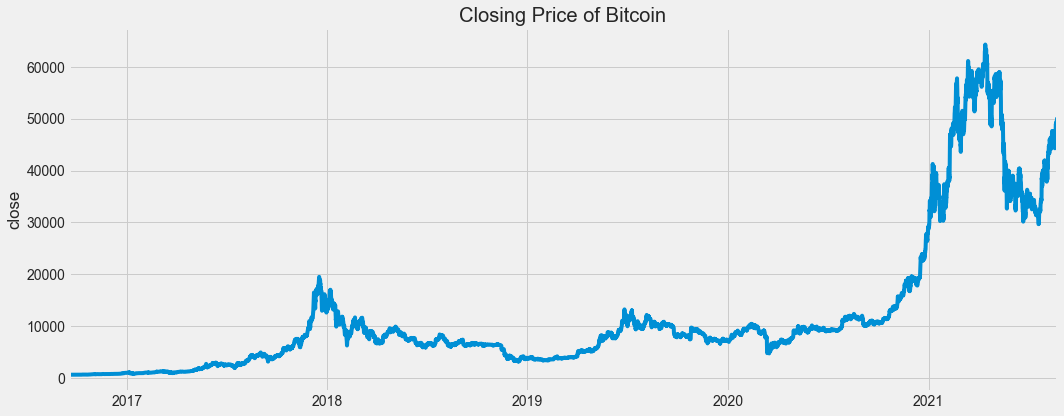

In [11]:
# Let's see a historical view of the closing price

plt.figure(figsize=(15, 6))
plt.subplots_adjust(top=1.25, bottom=1.2)

data['close'].plot()
plt.ylabel('close')
plt.xlabel(None)
plt.title(f"Closing Price of Bitcoin")
    
plt.tight_layout()

### Volumes traded

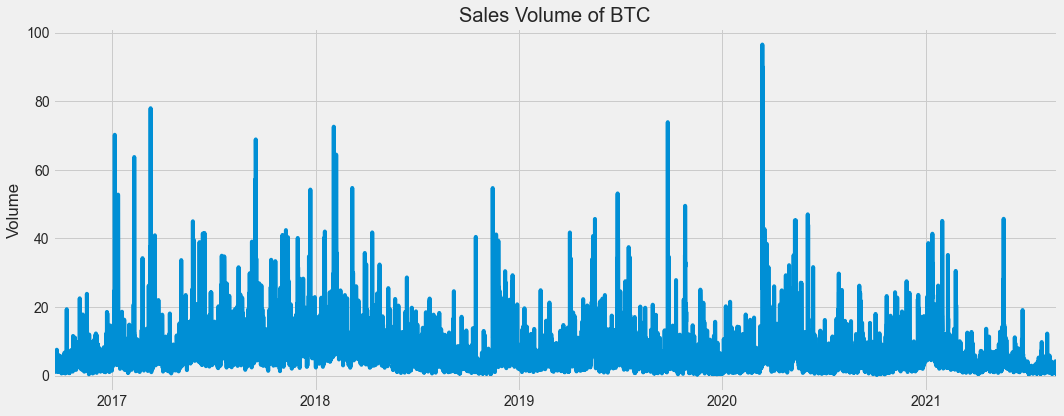

In [12]:
# Let's see a historical view of the closing price

plt.figure(figsize=(15, 6))
plt.subplots_adjust(top=1.25, bottom=1.2)

data['volume'].plot()
plt.ylabel('Volume')
plt.xlabel(None)
plt.title(f"Sales Volume of BTC")
    
plt.tight_layout()

In [13]:
data.tail(20)

,open,high,low,close,volume,log_open,log_high,log_low,log_close,ema12,dist_ema12,ema26,dist_ema26,ema21,dist_ema21,ema50,dist_ema50,ema34,dist_ema34,ema55,dist_ema55,ema99,dist_ema99,ema200,dist_ema200,rsi,K,D,sma,bollinger_up,bollinger_down,dist_bollinger_up,dist_bollinger_down,vol_roc,4h Return,4h Gradient,boll_width,high_low_avg,stoch_rsi,perc_bb
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-08-20 00:00:00,47129.845208,47149.649250,47109.826083,47131.101583,1.750643,10.760658,10.761078,10.760233,10.760684,45722.904541,1408.197042,45756.017576,1375.084007,45730.920230,1400.181354,45561.047732,1570.053852,45751.608237,1379.493346,45462.224053,1668.877531,44233.981756,2897.119827,41649.381341,5481.720242,62.691420,100.000000,80.508932,45559.262842,47139.992348,43978.533336,-8.890764,3152.568248,-0.231223,1.174636,547.191542,3161.459012,47129.737667,90.254466,0.997188
2021-08-20 04:00:00,47075.089167,47089.078125,47059.885833,47074.913875,1.128116,10.759497,10.759794,10.759174,10.759493,45930.905977,1144.007898,45853.713598,1221.200277,45853.101470,1221.812405,45620.415031,1454.498844,45827.225702,1247.688173,45519.820118,1555.093757,44290.800398,2784.113477,41703.366739,5371.547136,62.046543,99.219003,94.297810,45611.496437,47321.507959,43901.484916,-246.594084,3173.428959,-0.355599,-0.119216,-56.187708,3420.023043,47074.481979,96.758406,0.927897
2021-08-20 08:00:00,47066.319917,47082.718042,47049.676083,47068.914583,1.164499,10.759308,10.759656,10.758954,10.759363,46105.984224,962.930359,45943.728486,1125.186097,45963.629935,1105.284648,45677.218935,1391.695648,45898.179352,1170.735231,45575.144920,1493.769663,44346.362682,2722.551901,41756.755275,5312.159308,61.973241,98.349231,99.189411,45657.542421,47474.624787,43840.460054,-405.710204,3228.454529,0.032250,-0.012744,-5.999292,3634.164733,47066.197062,98.769321,0.888362
2021-08-20 12:00:00,47734.988875,47768.061417,47712.084083,47743.887625,4.191353,10.773345,10.774036,10.772867,10.773531,46357.969363,1385.918262,46077.073607,1666.814018,46125.471543,1618.416082,45758.264766,1985.622859,46003.648396,1740.239229,45652.600017,2091.287608,44414.313181,3329.574444,41816.328731,5927.558894,66.734903,98.349231,98.639155,45738.808177,47774.887985,43702.728370,-31.000360,4041.159255,2.599277,1.434010,674.973042,4072.159615,47740.072750,98.494193,0.992387
2021-08-20 16:00:00,48674.914458,48694.855000,48652.187958,48674.331333,1.645662,10.792915,10.793325,10.792448,10.792903,46714.332743,1959.998590,46269.463069,2404.868265,46357.186069,2317.145264,45872.620318,2801.711015,46156.258850,2518.072483,45760.518992,2913.812341,44499.513544,4174.817789,41884.567563,6789.763770,71.949272,99.130228,98.609563,45841.780040,48240.437790,43443.122289,433.893543,5231.209044,-0.607367,1.948823,930.443708,4797.315501,48673.521479,98.869896,1.090445
2021-08-20 20:00:00,48990.252500,49008.972667,48971.771292,48991.260583,1.851192,10.799366,10.799748,10.798989,10.799387,47064.629334,1926.631250,46471.077699,2520.182884,46596.647389,2394.613194,45994.919936,2996.340647,46318.258949,2673.001634,45875.902621,3115.357963,44589.348485,4401.912099,41955.280927,7035.979657,73.474496,100.000000,99.159820,45973.839629,48751.247766,43196.431492,240.012817,5794.829091,0.124892,0.651122,316.929250,5554.816273,48990.371979,99.579910,1.043208
2021-08-21 00:00:00,48983.552792,48997.188125,48964.829083,48980.856458,1.145075,10.799238,10.799516,10.798855,10.799183,47359.433507,1621.422952,46656.987237,2323.869221,46813.393668,2167.462790,46112.015486,2868.840972,46470.407378,2510.449080,45986.793829,2994.062629,44677.178644,4303.677814,42025.187151,6955.669308,73.333528,99.877334,99.669187,46135.628560,49217.247611,43054.009509,-236.391153,5926.846949,-0.381439,-0.021237,-10.404125,6163.238102,48981.008604,99.773261,0.961645
2021-08-21 04:00:00,48803.279542,48817.706208,48788.447833,48804.427875,1.369215,10.795551,10.795846,10.795247,10.795574,47581.740333,1222.687542,46816.056914,1988.370961,46994.396778,1810.031

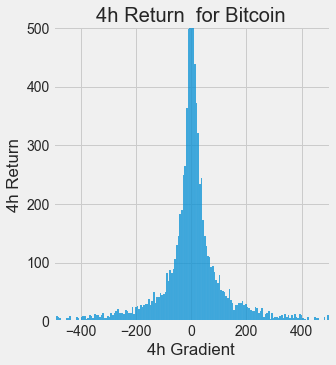

In [14]:
sns.displot(data = data, x= '4h Gradient')
plt.ylabel('4h Return')
plt.xlim([-500,500])
plt.ylim([0,500])
plt.title(f"4h Return  for Bitcoin");

In [15]:
data.columns

Index(['open', 'high', 'low', 'close', 'volume', 'log_open', 'log_high',
       'log_low', 'log_close', 'ema12', 'dist_ema12', 'ema26', 'dist_ema26',
       'ema21', 'dist_ema21', 'ema50', 'dist_ema50', 'ema34', 'dist_ema34',
       'ema55', 'dist_ema55', 'ema99', 'dist_ema99', 'ema200', 'dist_ema200',
       'rsi', 'K', 'D', 'sma', 'bollinger_up', 'bollinger_down',
       'dist_bollinger_up', 'dist_bollinger_down', 'vol_roc', '4h Return',
       '4h Gradient', 'boll_width', 'high_low_avg', 'stoch_rsi', 'perc_bb'],
      dtype='object')

In [16]:
selected_features = ['close','high','bollinger_up','rsi','4h Return']
#selected_features= ['close','rsi','ema34','bollinger_up','4h Return']
#selected_features=['close','rsi','ema20','ema50','bollinger_up','4h Return']
selected_data = data[selected_features]
selected_data.tail(10)

,close,high,bollinger_up,rsi,4h Return
date,,,,,
2021-08-21 16:00:00,49432.223667,49454.248292,50526.542459,74.543279,0.719512
2021-08-21 20:00:00,49173.217708,49189.245542,50761.056067,70.431748,-0.523962
2021-08-22 00:00:00,48942.428458,48954.110583,50938.534351,66.891324,-0.469339
2021-08-22 04:00:00,49134.101875,49141.857792,51041.673873,68.315817,0.391630
2021-08-22 08:00:00,49202.166042,49211.436458,51080.472949,68.828696,0.138527
2021-08-22 12:00:00,48769.737750,48787.711375,50912.659422,61.965840,-0.878881
2021-08-22 16:00:00,48591.580833,48605.941333,50660.931862,59.340648,-0.365302
2021-08-22 20:00:00,48810.168750,48825.874417,50371.206423,61.496021,0.449847
2021-08-23 00:00:00,49783.003708,49803.461792,50344.600752,69.296876,1.993099


##  BTC Stock Price

### Temporal Train-Test Split

In [17]:
train_percentage = 95

In [18]:
train_len = int(len(selected_data) * train_percentage/100)
train_len

10268

In [19]:
data_train = selected_data[:train_len]
data_test = selected_data[train_len:]


In [20]:
print(data_train.head(1))
print(data_train.tail(1))

                          close       high  bollinger_up        rsi  4h Return
date                                                                          
2016-09-16 20:00:00  606.412748  606.51145       609.507  43.241274   0.102042
                   close          high  bollinger_up        rsi  4h Return
date                                                                      
2021-05-25  38797.501625  38848.610542  40048.663186  54.171787  -0.114713


In [21]:
print(data_test.head(5))
print(data_test.tail(5))

                            close          high  bollinger_up        rsi  \
date                                                                       
2021-05-25 04:00:00  38533.763958  38573.571250  40260.559872  52.973394   
2021-05-25 08:00:00  37743.495167  37796.365583  40290.044419  49.443794   
2021-05-25 12:00:00  37546.907583  37599.467292  40364.054212  48.576709   
2021-05-25 16:00:00  37889.190000  37926.843375  40413.454343  50.213797   
2021-05-25 20:00:00  37979.078542  38006.089833  40389.429609  50.658053   

                     4h Return  
date                            
2021-05-25 04:00:00  -0.679780  
2021-05-25 08:00:00  -2.050848  
2021-05-25 12:00:00  -0.520852  
2021-05-25 16:00:00   0.911613  
2021-05-25 20:00:00   0.237241  
                            close          high  bollinger_up        rsi  \
date                                                                       
2021-08-22 12:00:00  48769.737750  48787.711375  50912.659422  61.965840   
2021-08-

## LSTM

In [22]:
from sklearn.preprocessing import MinMaxScaler

minmax_scaler = MinMaxScaler(feature_range = (0,1))

minmax_scaler.fit(data_train)

data_train_scaled = minmax_scaler.transform(data_train)
data_test_scaled = minmax_scaler.transform(data_test)

In [23]:
minmax_scaler.data_max_

array([6.43385212e+04, 6.43611598e+04, 6.59491557e+04, 9.65172066e+01,
       1.35906830e+01])

In [24]:
minmax_scaler.data_min_

array([594.18785714, 594.25053571, 601.386911  ,   4.66356567,
       -18.4592994 ])

In [25]:
min1 = minmax_scaler.data_min_[0]
min1

594.1878571428572

In [26]:
range1 = minmax_scaler.data_range_[0]
range1

63744.333309523805

### Creating subsequences...

In [27]:
window_size = 18 # test with small window size
horizon = 1 #number of predictions into the future :) 
data_train_subsequences = []
fake_y_train = []
for k in range(len(data_train_scaled)-(window_size-1)-horizon):
    data_train_subsequences.append(data_train_scaled[k:k+window_size])
    fake_y_train.append(data_train_scaled[k+window_size])

In [28]:
X_train = np.array(data_train_subsequences)
y_train = np.array(fake_y_train)[:,0].reshape(-1,1)

In [29]:
X_train.shape

(10250, 18, 5)

In [30]:
y_train.shape

(10250, 1)

In [31]:
#with the same window_size & horizon as the train data
window_size = 18
horizon = 1
data_test_subsequences = []
fake_y_test = []
for k in range(len(data_test_scaled)-(window_size-1)-horizon):
    data_test_subsequences.append(data_test_scaled[k:k+window_size])
    fake_y_test.append(data_test_scaled[k+window_size])

In [32]:
X_test = np.array(data_test_subsequences)
y_test = np.array(fake_y_test)[:,0].reshape(-1,1)

### Baseline

In [33]:
# baseline predictions

X_test_last_seen_value = [_[-1][0] for _ in X_test]

In [34]:
X_test_last_seen_value_uns = np.array(X_test_last_seen_value) * range1 + min1

In [35]:
X_test_last_seen_value_uns = X_test_last_seen_value_uns.reshape(-1,1)

In [36]:
y_test_unscaled = y_test * range1 + min1

In [37]:
np.mean(np.abs(y_test_unscaled - X_test_last_seen_value_uns))

368.74288851468793

### Baseline mape

In [38]:
baseline_mape = np.mean(np.abs((y_test_unscaled - X_test_last_seen_value_uns) / y_test_unscaled)) *100

In [39]:
baseline_mape 

0.994878389011856

### LSTM

#### RNN Architecture

In [40]:
from tensorflow.keras import Sequential, layers

# Build the LSTM model
model = Sequential()

model.add(layers.LSTM(units=256,
                     return_sequences = True,
                     activation = "tanh"))
                    #activation = "relu"
                    #input_shape = X_train[0].shape))
model.add(layers.Dropout(rate=0.2)) 
model.add(layers.LSTM(units=512,
                      return_sequences = False,
                      activation = "relu"))
model.add(layers.Dropout(rate=0.2)) 

# model.add(layers.Dense(25,
#                          activation="relu"))
model.add(layers.Dense(32,activation = "tanh"))

#model.add(layers.Dense(16,activation="relu"))

#model.add(layers.Dense(8,activation = "relu"))

model.add(layers.Dense(1,activation = "relu"))

#model.summary()



2021-09-01 11:50:40.040122: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [41]:
model.compile(loss="mse",
             optimizer = "adam",#rmsprop
             metrics = "mae"#[my_mae]
             )

#### Training

In [42]:
from tensorflow.keras.callbacks import EarlyStopping 

es = EarlyStopping(patience = 5, restore_best_weights=True, monitor = "mae")
#monitor = "val_mean_absolute_error"

history = model.fit(X_train, y_train,
                    validation_split = 0.2,
                    batch_size=16,
                    epochs=30,
                    verbose = 1,
                    callbacks = [es])

2021-09-01 11:50:40.207681: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30
513/513 [==============================] - 34s 62ms/step - loss: 3.9718e-04 - mae: 0.0091 - val_loss: 0.0059 - val_mae: 0.0495
Epoch 2/30
513/513 [==============================] - 30s 59ms/step - loss: 5.3762e-05 - mae: 0.0053 - val_loss: 0.0065 - val_mae: 0.0499
Epoch 3/30
513/513 [==============================] - 32s 62ms/step - loss: 3.9696e-05 - mae: 0.0046 - val_loss: 0.0075 - val_mae: 0.0562
Epoch 4/30
513/513 [==============================] - 31s 61ms/step - loss: 4.2084e-05 - mae: 0.0048 - val_loss: 0.0062 - val_mae: 0.0515
Epoch 5/30
513/513 [==============================] - 31s 60ms/step - loss: 4.2532e-05 - mae: 0.0048 - val_loss: 0.0103 - val_mae: 0.0654
Epoch 6/30
513/513 [==============================] - 31s 61ms/step - loss: 3.4042e-05 - mae: 0.0043 - val_loss: 0.0036 - val_mae: 0.0388
Epoch 7/30
513/513 [==============================] - 30s 58ms/step - loss: 3.4241e-05 - mae: 0.0043 - val_loss: 0.0059 - val_mae: 0.0501
Epoch 8/30
513/513 [==============

In [43]:
def plot_loss_mae(history):
    
    fig, ax =plt.subplots(1,2,figsize=(20,5))
    
    
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('Model loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].legend(['Train', 'Val'], loc='upper right')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)
    
#     # --- MAE

    #ax[1].plot(history.history['mean_absolute_error'])
    #ax[1].plot(history.history['val_mean_absolute_error'])
    #ax[1].set_title('Model MAE', fontsize = 18)
    #ax[1].set_xlabel('Epoch', fontsize = 14)
    #ax[1].set_ylabel('Recall', fontsize = 14)
    #ax[1].legend(['Train', 'Val'], loc='lower right') 
    #ax[1].grid(axis="x",linewidth=0.5)
    #ax[1].grid(axis="y",linewidth=0.5)   
    
    #plt.show()
    

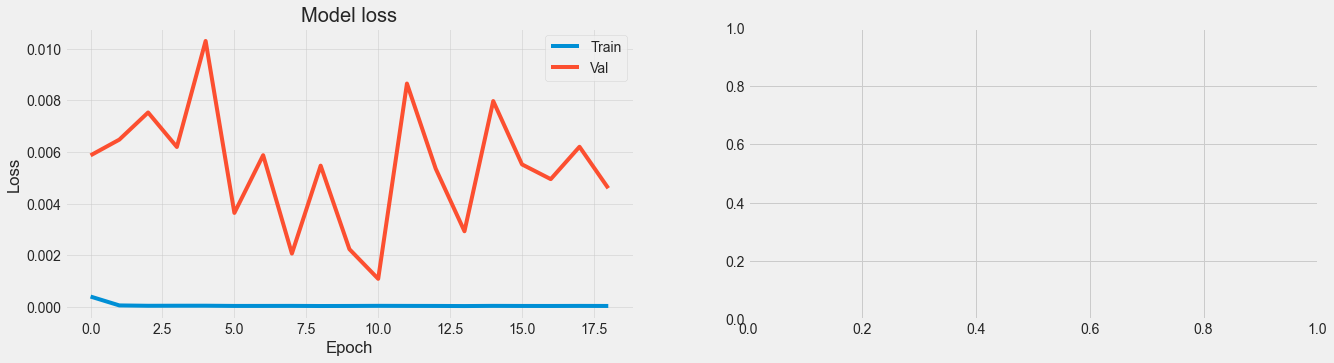

In [44]:
plot_loss_mae(history)

#### Evaluating

In [45]:
# res = model.evaluate(X_test, y_test, verbose = 1)
# res


#### Predictions

In [46]:
predictions = model.predict(X_test)


In [47]:
len(predictions), len(y_test)

(523, 523)

In [48]:
predictions[0:3]

array([[0.5617368],
       [0.5518701],
       [0.5392271]], dtype=float32)

In [49]:
y_test_unscaled = y_test * range1 + min1

In [50]:
predictions_unscaled = predictions * range1 + min1

In [51]:
print(pd.DataFrame(y_test_unscaled).tail(5))
print(pd.DataFrame(predictions_unscaled).tail(5))

                0
518  48769.737750
519  48591.580833
520  48810.168750
521  49783.003708
522  50277.475152
                0
518  44781.195312
519  44562.527344
520  44363.816406
521  44378.660156
522  44841.144531


The operation computed during a `MinMaxScaler` Operation is:

$$x_{scaled} = \frac{x - x_{min}}{x_{max}- x_{min}}$$

To descale it:

$$x = x_{scaled} * (x_{max}- x_{min}) + x_{min}$$

Or use the `inverse_transform` directly provided...

In [52]:
np.mean(np.abs(y_test_unscaled - predictions_unscaled))

2019.3252140106238

In [53]:
np.mean(np.abs((y_test_unscaled - predictions_unscaled) / y_test_unscaled)) *100

5.144281409189701

In [54]:
y_test_unscaled.shape

(523, 1)

In [55]:
predictions_unscaled.shape

(523, 1)

In [56]:
# from tensorflow.keras.models import load_model, save_model
# save_model(model,'close_high_bollinger_up_rsi_ema21')

In [57]:
# loss = np.mean(tf.keras.losses.mean_absolute_percentage_error(y_test_unscaled, predictions_unscaled))


In [58]:
import matplotlib.pyplot as plt


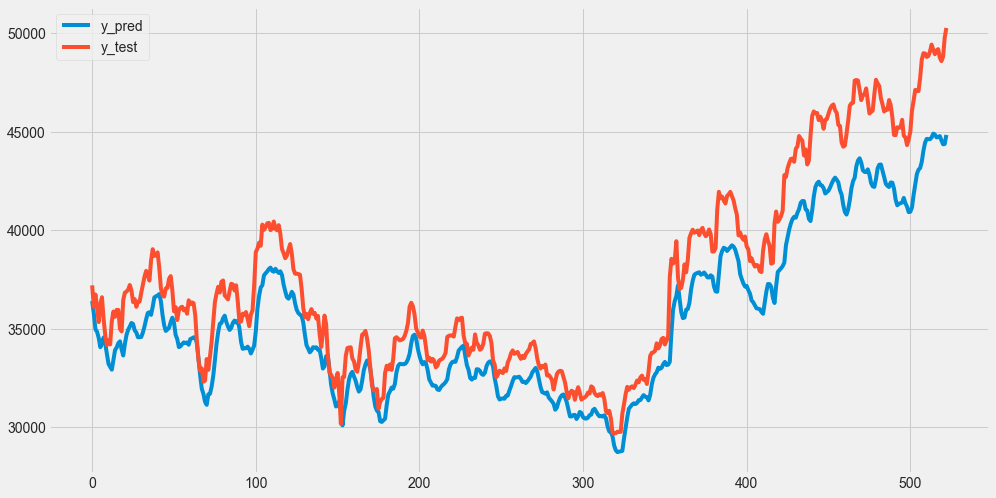

In [59]:
fig = plt.figure(figsize=(15, 8))

plt.plot(predictions_unscaled, label = "y_pred")
plt.plot(y_test_unscaled, label = "y_test")
plt.legend()
plt.show()

In [60]:
stop stop 

SyntaxError: invalid syntax (958000207.py, line 1)

In [ ]:
#import joblib
# from tensorflow.keras.models import load_model, save_model
# save_model(model, "rsi_boll_up_down_4h_return")

### Test Model on Coingecko

In [ ]:
coingecko = get_coingecko()

In [ ]:
feature_engineer(coingecko)

In [ ]:
get_xgecko(length=60, horizon=1)

### Test based on 1 window_size and 1 prediction (4 hours in de future) with Coingecko Data

In [ ]:
X_gecko = coingecko.dropna()[-18:]

In [ ]:
X_gecko.shape

In [ ]:
x_gecko_scaled = minmax_scaler.transform(X_gecko)

In [ ]:
x_gecko_scaled_reshaped = x_gecko_scaled.reshape(1,18,4) #18 is the window size, 9 is number of features. 

In [ ]:
predictions_api = model.predict(x_gecko_scaled_reshaped)

In [ ]:
predictions_api

In [ ]:
predictions_api_unscaled = predictions_api * range1 + min1 

In [ ]:
predictions_api_unscaled


### Creating X_test_gecko and y_test_gecko

In [ ]:
X_test_gecko = coingecko.dropna()[-144:]

In [ ]:
print(X_test_gecko.head(1))
print(X_test_gecko.tail(1))

In [ ]:
X_test_gecko_scaled = minmax_scaler.transform(X_test_gecko)

In [ ]:
X_test_gecko.shape

In [ ]:
#with the same window_size & horizon as the train data
window_size = 18
horizon = 1
X_test_gecko_sub = []
fake_y_test_gecko_sub = []
for k in range(len(X_test_gecko_scaled)-(window_size-1)-horizon):
    X_test_gecko_sub.append(X_test_gecko_scaled[k:k+window_size])
    fake_y_test_gecko_sub.append(X_test_gecko_scaled[k+window_size])

In [ ]:
X_test_gecko_np = np.array(X_test_gecko_sub)
y_test_gecko_np = np.array(fake_y_test_gecko_sub)[:,0].reshape(-1,1)

In [ ]:
print(X_test_gecko_np.shape)
print(y_test_gecko_np.shape)

In [ ]:
predictions_gecko = model.predict(X_test_gecko_np)

In [ ]:
predictions_gecko_unscaled = predictions_gecko * range1 + min1

In [ ]:
predictions_gecko_unscaled

In [ ]:
y_test_gecko_unscaled = y_test_gecko_np * range1 + min1

In [ ]:
np.mean(np.abs(y_test_gecko_unscaled - predictions_gecko_unscaled))

In [ ]:
fig = plt.figure(figsize=(15, 8))
plt.plot(predictions_gecko_unscaled, label = "y_pred_gecko")
plt.plot(y_test_gecko_unscaled, label = "y_real_gecko")
plt.legend()
plt.show()